# `longshots_do_well_in_extreme_weather_conditions.ipynb`

### Author: Anthony Hein

#### Last updated: 11/8/2021

# Overview:

This notebook shows that longshots do well in extreme weather conditions.

---

## Setup

In [1]:
from datetime import datetime
import git
import os
import re
from typing import List
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `races_featurized.csv`

In [3]:
races_featurized = pd.read_csv(f"{BASE_DIR}/data/streamline/races_featurized.csv", low_memory=False) 
races_featurized.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4,entropy of odds
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,0,1,0,0,0,0,0,0,1,1.350363
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,1,0,0,1,0,0,0,0,1,1.995151
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,1,0,0,0,0,0,0,1,0,1.786421
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,0,1,0,0,0,0,0,1,0,1.611062
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,1,0,0,0,0,0,1,0,0,1.254374


In [4]:
races_featurized.shape

(20201, 129)

In [5]:
list(races_featurized.columns)

['rid',
 'course',
 'title',
 'winningTime',
 'metric',
 'ncond',
 'class',
 'runners',
 'margin',
 '1st_place_rank_in_odds',
 '2nd_place_rank_in_odds',
 '3rd_place_rank_in_odds',
 '1st_rank_in_odds_place',
 '2nd_rank_in_odds_place',
 '3rd_rank_in_odds_place',
 'placeAvailable',
 'showAvailable',
 'favoriteWon',
 'favoritePlaced',
 'favoriteShowed',
 'lat',
 'lng',
 'datetime',
 'station no',
 'station name',
 'station lat',
 'station lng',
 'dist to station',
 'station reading date',
 'temp',
 'msl',
 'rain',
 'rhum',
 'station reading timedelta',
 'course__Ballinrobe',
 'course__Bellewstown',
 'course__Clonmel',
 'course__Cork',
 'course__Curragh',
 'course__Down Royal',
 'course__Downpatrick',
 'course__Dundalk',
 'course__Fairyhouse',
 'course__Galway',
 'course__Gowran Park',
 'course__Killarney',
 'course__Leopardstown',
 'course__Limerick',
 'course__Listowel',
 'course__Naas',
 'course__Navan',
 'course__Other',
 'course__Punchestown',
 'course__Roscommon',
 'course__Sligo',
 '

---

## Load `horses_selected_trimmed_clean.csv`

In [6]:
horses_clean = pd.read_csv(f"{BASE_DIR}/data/streamline/horses_selected_trimmed_clean.csv", low_memory=False) 
horses_clean.head()

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,RPR,TR,OR,father,mother,gfather,weight,res_win,res_place,res_show
0,302858,Kings Return,6.0,4.0,0.600000,1,W P Mullins,D J Casey,1,0,...,102.0,NaN,NaN,King's Ride,Browne's Return,Deep Run,73,1,1,0
1,302858,Majestic Red I,6.0,5.0,0.047619,0,John Hackett,Conor O'Dwyer,2,8,...,94.0,NaN,NaN,Long Pond,Courtlough Lady,Giolla Mear,73,0,1,0
2,302858,Clearly Canadian,6.0,2.0,0.166667,0,D T Hughes,G Cotter,3,1.5,...,92.0,NaN,NaN,Nordico,Over The Seas,North Summit,71,0,0,0
3,302858,Bernestic Wonder,8.0,1.0,0.058824,0,E McNamara,J Old Jones,4,dist,...,NaN,NaN,NaN,Roselier,Miss Reindeer,Reindeer,73,0,0,0
4,302858,Beauty's Pride,5.0,6.0,0.038462,0,J J Lennon,T Martin,5,dist,...,NaN,NaN,NaN,Noalto,Elena's Beauty,Tarqogan,66,0,0,0


In [7]:
horses_clean.shape

(202304, 22)

---

## Longshots Do Well In Extreme Weather Conditions

In [8]:
dfa = races_featurized[
    ((races_featurized['temp_level_1'] == 1) | (races_featurized['temp_level_2'] == 1) | (races_featurized['temp_level_3'] == 1)) &
    ((races_featurized['pressure_level_3'] == 1) | (races_featurized['pressure_level_4'] == 1)) &
    ((races_featurized['rhum_level_1'] == 1) | (races_featurized['rhum_level_2'] == 1) | (races_featurized['rhum_level_3'] == 1)) &
    (races_featurized['is_raining'] == 0)
]

dfb = races_featurized[
    ~(((races_featurized['temp_level_1'] == 1) | (races_featurized['temp_level_2'] == 1) | (races_featurized['temp_level_3'] == 1)) &
    ((races_featurized['pressure_level_3'] == 1) | (races_featurized['pressure_level_4'] == 1)) &
    ((races_featurized['rhum_level_1'] == 1) | (races_featurized['rhum_level_2'] == 1) | (races_featurized['rhum_level_3'] == 1)) &
    (races_featurized['is_raining'] == 0))
]

len(dfa), len(dfb)

(10520, 9681)

In [9]:
np.mean(dfa['1st_place_rank_in_odds'])

2.8202471482889733

In [10]:
np.mean(dfa['2nd_place_rank_in_odds'])

3.492110266159696

In [11]:
np.mean(dfa['3rd_place_rank_in_odds'])

4.037072243346008

In [12]:
np.mean(dfb['1st_place_rank_in_odds'])

2.973349860551596

In [13]:
np.mean(dfb['2nd_place_rank_in_odds'])

3.56006610887305

In [14]:
np.mean(dfb['3rd_place_rank_in_odds'])

4.218469166408429

In [15]:
stats.ttest_ind(dfa['1st_place_rank_in_odds'],
                dfb['1st_place_rank_in_odds'],
                equal_var=False)

Ttest_indResult(statistic=-4.682453427434571, pvalue=2.8533996199699396e-06)

In [16]:
stats.ttest_ind(dfa['2nd_place_rank_in_odds'],
                dfb['2nd_place_rank_in_odds'],
                equal_var=False)

Ttest_indResult(statistic=-1.94099925516113, pvalue=0.05227248256786023)

In [17]:
stats.ttest_ind(dfa['3rd_place_rank_in_odds'],
                dfb['3rd_place_rank_in_odds'],
                equal_var=False)

Ttest_indResult(statistic=-4.97151041447988, pvalue=6.698672928325066e-07)

(array([0.43693833, 0.10122921, 0.06666508, 0.09074078, 0.02510866,
        0.01819583, 0.01954661, 0.0056415 , 0.00333723, 0.00182753]),
 array([ 1. ,  2.3,  3.6,  4.9,  6.2,  7.5,  8.8, 10.1, 11.4, 12.7, 14. ]),
 <BarContainer object of 10 artists>)

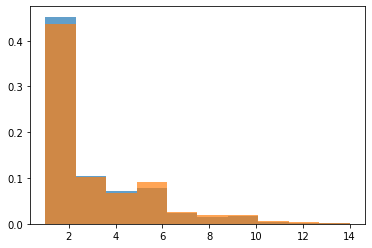

In [18]:
plt.hist(dfa['1st_place_rank_in_odds'], alpha = 0.7, density=True)
plt.hist(dfb['1st_place_rank_in_odds'], alpha = 0.7, density=True)

(array([[0.45239836, 0.1044165 , 0.07180462, 0.07831237, 0.02281369,
         0.01469728, 0.01659842, 0.00409476, 0.00263235, 0.00146242],
        [0.43693833, 0.10122921, 0.06666508, 0.09074078, 0.02510866,
         0.01819583, 0.01954661, 0.0056415 , 0.00333723, 0.00182753]]),
 array([ 1. ,  2.3,  3.6,  4.9,  6.2,  7.5,  8.8, 10.1, 11.4, 12.7, 14. ]),
 <a list of 2 BarContainer objects>)

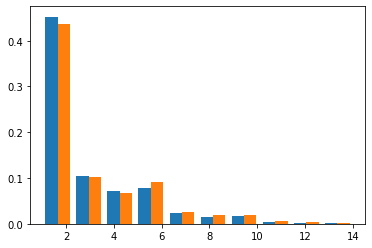

In [19]:
plt.hist([dfa['1st_place_rank_in_odds'], dfb['1st_place_rank_in_odds']], density=True)

(array([[0.33971922, 0.12554841, 0.0952764 , 0.11406844, 0.03582919,
         0.02288681, 0.02317929, 0.00680023, 0.00365604, 0.00226674],
        [0.33904635, 0.12006071, 0.09368072, 0.11378354, 0.03551763,
         0.02336059, 0.02828697, 0.0071512 , 0.00484692, 0.00349614]]),
 array([ 1. ,  2.3,  3.6,  4.9,  6.2,  7.5,  8.8, 10.1, 11.4, 12.7, 14. ]),
 <a list of 2 BarContainer objects>)

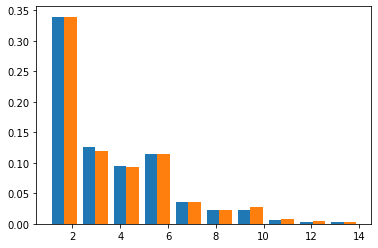

In [20]:
plt.hist([dfa['2nd_place_rank_in_odds'], dfb['2nd_place_rank_in_odds']], density=True)

(array([[0.24385785, 0.14200058, 0.10982743, 0.15165253, 0.04036268,
         0.03049137, 0.03385493, 0.00884762, 0.00548406, 0.00285171],
        [0.23003027, 0.13619064, 0.11243276, 0.15152599, 0.04362232,
         0.03329281, 0.03972889, 0.0092171 , 0.00746903, 0.00572096]]),
 array([ 1. ,  2.3,  3.6,  4.9,  6.2,  7.5,  8.8, 10.1, 11.4, 12.7, 14. ]),
 <a list of 2 BarContainer objects>)

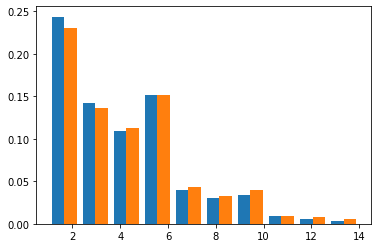

In [21]:
plt.hist([dfa['3rd_place_rank_in_odds'], dfb['3rd_place_rank_in_odds']], density=True)

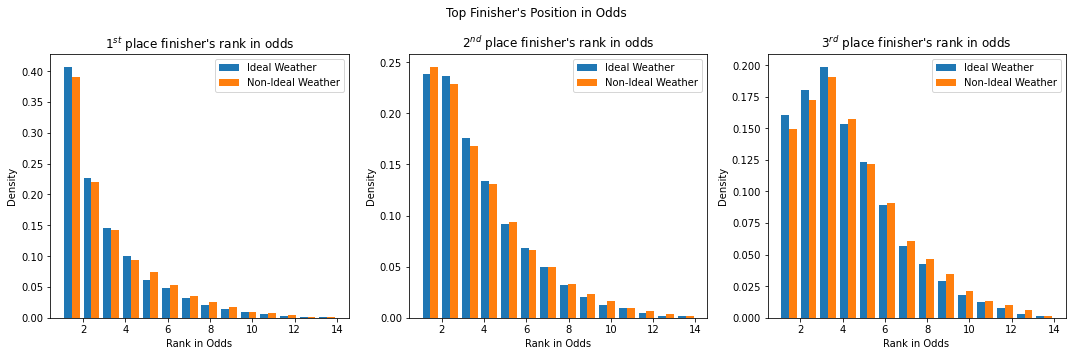

In [48]:
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(1, 3)

fig.suptitle("Top Finisher's Position in Odds")

ax1 = fig.add_subplot(gs[0:1, 0:1])
ax2 = fig.add_subplot(gs[0:1, 1:2])
ax3 = fig.add_subplot(gs[0:1, 2:3])

ax1.set_title("$1^{st}$ place finisher's rank in odds")
ax1.hist([dfa['1st_place_rank_in_odds'], dfb['1st_place_rank_in_odds']],
         label=['Ideal Weather', 'Non-Ideal Weather'],
         bins=14,
         density=True)
ax1.set_xlabel("Rank in Odds")
ax1.set_ylabel("Density")
ax1.legend()

ax2.set_title("$2^{nd}$ place finisher's rank in odds")
ax2.hist([dfa['2nd_place_rank_in_odds'], dfb['2nd_place_rank_in_odds']],
         label=['Ideal Weather', 'Non-Ideal Weather'],
         bins=14,
         density=True)
ax2.set_xlabel("Rank in Odds")
ax2.set_ylabel("Density")
ax2.legend()

ax3.set_title("$3^{rd}$ place finisher's rank in odds")
ax3.hist([dfa['3rd_place_rank_in_odds'], dfb['3rd_place_rank_in_odds']],
         label=['Ideal Weather', 'Non-Ideal Weather'],
         bins=14,
         density=True)
ax3.set_xlabel("Rank in Odds")
ax3.set_ylabel("Density")
ax3.legend()

plt.tight_layout()

fig.savefig(f"{BASE_DIR}/figures/top_finishers_position_in_odds.png")

plt.show()

array([[<AxesSubplot:title={'center':'1st_place_rank_in_odds'}>]],
      dtype=object)

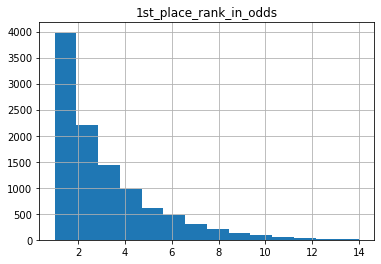

In [22]:
dfa.hist('1st_place_rank_in_odds', bins=14)

array([[<AxesSubplot:title={'center':'1st_place_rank_in_odds'}>]],
      dtype=object)

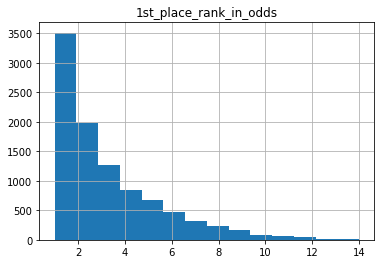

In [23]:
dfb.hist('1st_place_rank_in_odds', bins=14)

In [24]:
np.mean(dfa['1st_place_rank_in_odds'] > 3)

0.2761406844106464

In [25]:
np.mean(dfb['1st_place_rank_in_odds'] > 3)

0.3003821919223221

In [26]:
stats.ttest_ind(dfa[dfa['runners'] > 3]['1st_place_rank_in_odds'] > 3,
                dfb[dfb['runners'] > 3]['1st_place_rank_in_odds'] > 3,
                equal_var=False)

Ttest_indResult(statistic=-3.6104231230350954, pvalue=0.00030645237872801095)

In [27]:
longest_shot = races_featurized[races_featurized['1st_place_rank_in_odds'] == races_featurized['runners']]
longest_shot[['rid', 'title', 'datetime', 'ncond', 'rain', 'msl', 'temp', 'rhum', 'runners', '1st_place_rank_in_odds']]

,rid,title,datetime,ncond,rain,msl,temp,rhum,runners,1st_place_rank_in_odds
22,332935,Eve's Fashion Store (Limerick) EBF Handicap,1997-06-05 19:00:00,1,0.3,1000.5,16.0,79,5,5
39,367954,Tusker House Hotel &amp; Junction Night Club H...,1997-07-04 19:00:00,4,0.0,1022.2,15.4,82,4,4
48,383337,Aghadoe I.N.H. Flat Race,1997-07-17 16:35:00,4,0.0,1021.7,18.8,57,4,4
56,400821,Meld Stakes (Group 3),1997-07-26 15:05:00,1,0.0,1009.2,17.0,90,5,5
142,19606,Victor McCalmont Tetarch Stakes (Group 3),1994-04-23 14:30:00,9,0.1,991.7,13.4,59,4,4
...,...,...,...,...,...,...,...,...,...,...
19682,90012,Germinal Seed Handicap,1999-06-03 18:30:00,1,0.0,1001.9,15.9,74,10,10
20128,14654,Autumn Handicap,1999-10-16 15:50:00,11,0.0,1019.7,13.7,93,12,12
20141,318810,E.B.F. Premier Fillies Nursery Handicap,1999-10-23 14:30:00,5,0.0,979.4,13.4,86,8,8
20151,221205,Bewleys Hotels Handicap Chase,1999-10-24 14:45:00,5,1.9,980.0,12.3,92,7,7


In [28]:
np.mean(longest_shot['temp'])

14.260077519379845

In [29]:
np.mean(longest_shot['msl'])

1012.1527131782944

In [30]:
np.mean(longest_shot['rhum'])

72.36434108527132

In [31]:
np.mean(longest_shot['rain'])

0.15930232558139534

In [32]:
not_longest_shot = races_featurized[races_featurized['1st_place_rank_in_odds'] != races_featurized['runners']]
not_longest_shot[['rid', 'title', 'datetime', 'ncond', 'rain', 'msl', 'temp', 'rhum', 'runners', '1st_place_rank_in_odds']]

,rid,title,datetime,ncond,rain,msl,temp,rhum,runners,1st_place_rank_in_odds
0,302858,Liffey Maiden Hurdle (Div 1),1997-01-09 12:15:00,1,0.0,1012.4,1.6,87,6,1
1,291347,Ericsson G.S.M. Grand National Trial Handicap ...,1997-02-16 14:40:00,5,0.4,992.5,8.0,87,9,4
2,75447,Ballybunion E.B.F. Beginners S'chase,1997-03-01 14:00:00,5,0.0,1003.5,12.0,73,8,3
3,358038,Quinns Of Baltinglass Chase (La Touche) (Cross...,1997-04-24 13:40:00,1,0.0,1011.9,12.6,72,10,1
4,89211,Topaz Sprint Stakes (Listed),1997-05-08 17:30:00,4,0.0,994.2,11.1,59,5,4
...,...,...,...,...,...,...,...,...,...,...
20196,243638,Down Royal Bookmakers I.N.H. Flat Race,1999-12-27 14:30:00,9,0.0,988.8,2.5,93,14,3
20197,44932,Clintons of Clonmel Great Winter Sale Flat Race,1999-12-27 14:35:00,12,0.0,989.8,3.5,86,12,1
20198,35003,P.B. Bumper Flat Race,1999-12-28 14:40:00,5,0.0,1008.2,2.8,84,12,1
20199,360255,Farewell to the 20th Century Flat Race,1999-12-29 14:45:00,11,0.0,1021.0,4.1,85,10,5


In [33]:
np.mean(not_longest_shot['temp'])

13.829604372461514

In [34]:
np.mean(not_longest_shot['msl'])

1013.3644236072807

In [35]:
np.mean(not_longest_shot['rhum'])

73.71754500325929

In [36]:
np.mean(not_longest_shot['rain'])

0.11519330090758663

In [37]:
max(longest_shot['1st_place_rank_in_odds'])

14

In [38]:
longest_shot[longest_shot['1st_place_rank_in_odds'] == 14][['rid', 'title', 'datetime', 'ncond', 'rain', 'msl', 'temp', 'rhum']]

,rid,title,datetime,ncond,rain,msl,temp,rhum
877,51050,"Ladies Day At Roscommon On Monday, 9th July, 2...",2018-06-11 18:00:00,2,0.0,1020.0,14.4,76
2198,60007,Kildare Village Ladies Derby Handicap,2019-07-20 16:45:00,1,0.0,1010.6,17.1,70
3275,285815,Kilsaran Handicap (Div II),2009-08-29 17:05:00,0,0.0,1017.6,13.8,76
3648,402852,Fundraise At Dundalk Stadium Handicap (Div II),2020-02-21 19:00:00,0,2.0,1003.2,9.9,90
4271,410367,Tipperary Handicap,2020-09-14 16:30:00,1,0.0,1015.4,17.2,88
5361,202150,Navan Shopping Centre Handicap,2008-09-26 20:40:00,0,0.0,1032.0,14.2,71
6429,185991,Dundalk Stadium On Facebook Handicap (Div I),2012-10-05 20:00:00,0,0.1,1008.3,6.1,95
7474,380205,Cunnane Stratton Reynolds Handicap,2007-06-22 17:55:00,11,0.0,1009.8,18.1,68
8760,352490,Reiss Handicap,2013-09-13 16:45:00,2,0.0,1019.1,11.6,87
9759,76419,Hen &amp; Stag Packages At Dundalk Stadium Han...,2011-04-30 15:40:00,0,0.0,1012.5,17.9,34
